In [1]:

import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras


2025-11-07 19:01:33.463690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 19:01:33.496519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 19:01:34.442664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


we load the images and labels into a np array

In [2]:
pixel_size = 150
data_folder = f"A1_data_{pixel_size}"
images_path = os.path.join(data_folder, "images.npy")
images = np.load(images_path)
images = images.astype('float32') / 255.0  # Normalize images
labels_path = os.path.join(data_folder, "labels.npy")
labels = np.load(labels_path)
#set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Classification
For our first experiment, we will treat the problem as a classification model
We will run this experiment with 12, 72, and 720 classes

Function that allows us to make N_classes (note: it does not work for less than 12 classes)

In [7]:

def get_cat_labels(labels, N_classes):
    new_labels = []
    for label in labels:
        label = label[0]* N_classes/12+ int(label[1]* N_classes/(12*60))

        new_labels.append(int(label))
    return np.array(new_labels)


We then split the data into training, validation, and test sets. The sklearn train_test_split method shuffles the data by default

In [10]:

X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1.


We define a common sense Error. This calculates how far of the prediction was

In [4]:
def make_common_sense_loss(num_classes=24.0):
    def common_sense_loss(y_true, y_pred):
        y_pred_class = tf.argmax(y_pred, axis=1)
        y_true_float = tf.cast(tf.squeeze(y_true), dtype=tf.float32)
        y_pred_float = tf.cast(y_pred_class, dtype=tf.float32)
        diff = tf.abs(y_true_float - y_pred_float)
        cyclical_diff = tf.minimum(diff, num_classes- diff)
        return tf.reduce_mean(cyclical_diff * 720 /num_classes)
    return common_sense_loss

We define our model architecture
We use a learning rate reducer to reduce our learning rate when no improvement is found after 5 epochs, stop our training if there is no improvement for 7 epochs, and use a csv logger to store how our losses develop during training.


In [ ]:
def create_model(num_classes=24):
    lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=5,          # Wait 5 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
    early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,          # Wait 7 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
    csv_logger = keras.callbacks.CSVLogger(
    filename=f"classification_log{num_classes}_classes.csv",
    separator=",",
    append=True)  #makes sure results are appended to same file if training stops and is resumed
    model= keras.models.Sequential([
        keras.Input(shape=(pixel_size, pixel_size, 1)),
        # Block 1
        keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Dropout(0.1),
        # Block 2
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.1),
        # Block 3
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.1),
        # Block 4
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),
        keras.layers.Dropout(0.1),


        keras.layers.Flatten(),
        keras.layers.Dense(128, activation="leaky_relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="leaky_relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(int(num_classes), activation="softmax")
    ])
    cse = make_common_sense_loss(num_classes=num_classes)
    model.compile(loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[cse,"Accuracy"
            ],
    )
    return model, lr_scheduler, early_stopper, csv_logger


In [ ]:

model = keras.models.load_model('classification_model_720_classes.keras',
custom_objects={'common_sense_loss': make_common_sense_loss(num_classes=720)})
train_labels = get_cat_labels(y_train,720)
valid_labels = get_cat_labels(y_valid,720)
_, lr_scheduler, early_stopper, csv_logger = create_model(num_classes=720)
model.fit(
        X_train, train_labels,
        epochs=70,
        batch_size=16,
        validation_data=(X_valid, valid_labels),
        callbacks=[lr_scheduler, early_stopper, csv_logger]
    )
for num_classes in [12,72,720]:
    model, lr_scheduler, early_stopper, csv_logger = create_model(num_classes=num_classes)
    train_labels = get_cat_labels(y_train,num_classes)
    valid_labels = get_cat_labels(y_valid,num_classes)
    test_labels = get_cat_labels(y_test,num_classes)
    history = model.fit(
        X_train, train_labels,
        epochs=50,
        batch_size=16,
        validation_data=(X_valid, valid_labels),
        callbacks=[lr_scheduler, early_stopper, csv_logger]
    )
    test_loss, test_cse, test_accuracy = model.evaluate(X_test, test_labels)
    model.save(f"classification_model_{num_classes}_classes.keras")
    print(f"{num_classes} Classes: \n Test Loss: {test_loss}, Test Common Sense Error: {test_cse}, Test Accuracy: {test_accuracy}")

Epoch 1/50


E0000 00:00:1762532936.896961   24174 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-07 17:28:57.815991: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


900/900 ━━━━━━━━━━━━━━━━━━━━ 69s 69ms/step - Accuracy: 0.0847 - common_sense_loss: 99.2120 - loss: 4.2672 - val_Accuracy: 0.0700 - val_common_sense_loss: 96.1571 - val_loss: 4.2183 - learning_rate: 1.0000e-05
Epoch 2/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - Accuracy: 0.0867 - common_sense_loss: 99.4926 - loss: 4.2388 - val_Accuracy: 0.0744 - val_common_sense_loss: 95.9995 - val_loss: 4.1724 - learning_rate: 1.0000e-05
Epoch 3/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - Accuracy: 0.0898 - common_sense_loss: 98.9327 - loss: 4.2016 - val_Accuracy: 0.0717 - val_common_sense_loss: 96.8197 - val_loss: 4.1667 - learning_rate: 1.0000e-05
Epoch 4/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - Accuracy: 0.0908 - common_sense_loss: 98.4675 - loss: 4.1649 - val_Accuracy: 0.0750 - val_common_sense_loss: 97.9204 - val_loss: 4.1456 - learning_rate: 1.0000e-05
Epoch 5/50
900/900 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - Accuracy: 0.0906 - common_sense_loss: 97.0355 - loss: 4.1485 - val_Accuracy

Regression model. less dropout as this is less prone to overfitting

feat prep

In [22]:
import sklearn.preprocessing
labels_minutes = labels[:,0]*60 + labels[:,1]
labels_minutes = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(labels_minutes.reshape(-1,1)).flatten()
images = images.astype('float32') / 255.0
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels_minutes, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
)

In [23]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,          # halve the learning rate if there is no improvement
    patience=3,          # Wait 3 epochs with no improvement before reducing
    min_lr=1e-6          # Set a minimum learning rate at 1e-6
)
early_stopper = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,          # Wait 5 epochs for improvement before stopping
    restore_best_weights=True  # Automatically restore the weights from the best epoch
)
csv_logger = keras.callbacks.CSVLogger(
filename=f"regression_log.csv",
separator=",",
append=True)
model= keras.models.Sequential([
    keras.Input(shape=(pixel_size, pixel_size, 1)),
    #feature augmentation
    keras.layers.RandomRotation(factor=(12 / 360)),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    # Block 1
    keras.layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Dropout(0.1),
    # Block 2
    keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    # keras.layers.Dropout(0.1),
    # Block 3
    keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    # keras.layers.Dropout(0.1),
    # Block 4
    keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), activation="relu", padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2),
    # keras.layers.Dropout(0.1),


    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="leaky_relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="leaky_relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="linear")
])

model.compile(loss='mean_squared_error',
optimizer=keras.optimizers.Adam(learning_rate=0.001),
metrics=['MeanAbsoluteError'],
)

In [ ]:
model.fit(
    X_train, y_train,
    epochs=50,
    # batch_size=16,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler, early_stopper, csv_logger]
)

Epoch 1/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - MeanAbsoluteError: 0.7733 - loss: 4.4565 - val_MeanAbsoluteError: 0.3505 - val_loss: 0.1845 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - MeanAbsoluteError: 0.4866 - loss: 0.3777 - val_MeanAbsoluteError: 0.3285 - val_loss: 0.1601 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - MeanAbsoluteError: 0.4684 - loss: 0.3522 - val_MeanAbsoluteError: 0.6163 - val_loss: 0.8682 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - MeanAbsoluteError: 0.4632 - loss: 0.3425 - val_MeanAbsoluteError: 0.2435 - val_loss: 0.0854 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - MeanAbsoluteError: 0.4435 - loss: 0.3131 - val_MeanAbsoluteError: 0.3340 - val_loss: 0.1901 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 82ms/step - MeanAbsoluteError: 0.3977 - loss: 0.2501 - val_MeanAbsoluteError: 0.3412 - val_loss:

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

def common_sense_error_minutes(t_test, y_pred):
    error = abs(y_test - y_pred)
    error = np.minimum(error, 0.5 - error)
    return np.mean(error)

c_s_e = common_sense_error_minutes(y_test, y_pred)
print(f"Common Sense Error: {c_s_e*720:.2f}minutes")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - MeanAbsoluteError: 0.2027 - loss: 0.0627
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Common Sense Error: 76.09minutes


Multi-head model 

In [59]:

inputs = keras.Input(shape=(pixel_size, pixel_size, 1), name="input_images")
x = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Dropout(0.15)(x)

x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Dropout(0.15)(x)


x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation="leaky_relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.3)(x)
hour_branch = keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
hour_branch = keras.layers.Dropout(0.3)(hour_branch)
hour_output = keras.layers.Dense(2, activation="tanh", name="hour_output")(hour_branch)
minute_branch = keras.layers.Dense(128, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001)
                                   )(x)
minute_branch = keras.layers.Dropout(0.3)(minute_branch)
minute_output = keras.layers.Dense(2, activation="linear", name="minute_output")(minute_branch)

model = keras.Model(inputs=inputs, outputs=[hour_output, minute_output])
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss={
        "hour_output": "mean_squared_error",
        "minute_output": "mean_squared_error"
    },
    metrics={
        "hour_output": "mean_absolute_error",
        "minute_output": 'mean_absolute_error'
    }
)
for layer in model.layers:
    print(layer.name, '\n',layer.get_config())


input_images 
 {'batch_shape': (None, 150, 150, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_images'}
conv2d_50 
 {'name': 'conv2d_50', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
batch_normalization_60 
 {'name': 'batch_normalization_60', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTy

In [46]:
#label prep for multi head model
X_train_full, X_test,y_train_full, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=35
)
X_train, X_valid,y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=1/9, random_state=35
) # 1/9 x 0.9 = 0.1.

y_hour_train = y_train[:,0] / 12.0
y_minute_train = y_train[:,1] / 60.0
y_hour_valid = y_valid[:,0] / 12.0
y_minute_valid = y_valid[:,1] / 60.0
y_hour_test = y_test[:,0] / 12.0
y_minute_test = y_test[:,1] / 60.0


In [ ]:
model = create_multi_head_model(1)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=3,          # Wait 3 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,          # Wait 5 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
csv_logger = keras.callbacks.CSVLogger(
    filename="time_dual_head_training_log.csv",
    separator=",",
    append=True  #makes sure results are appended to same file if training stops and is resumed
)

model.fit(
    X_train, {"hour_output": y_hour_train, "minute_output": y_minute_train},
    epochs=60,
    loss_weights={"hour_output": 1, "minute_output": 0.5},
    validation_data=(X_valid, {"hour_output": y_hour_valid, "minute_output": y_minute_valid}),
    callbacks=[lr_scheduler, early_stopper, csv_logger]
    )


Epoch 1/60


Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
2025-11-08 10:31:41.268993: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-08 10:31:41.365515: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: 

449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - hour_output_loss: 0.3579 - hour_output_mean_absolute_error: 0.5043 - loss: 172.1055 - minute_output_loss: 171.5168 - minute_output_mean_absolute_error: 3.2327

Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
2025-11-08 10:32:07.465350: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-11-08 10:32:07.552430: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: 

450/450 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - hour_output_loss: 0.2286 - hour_output_mean_absolute_error: 0.3846 - loss: 31.8326 - minute_output_loss: 31.4061 - minute_output_mean_absolute_error: 1.0460 - val_hour_output_loss: 0.1207 - val_hour_output_mean_absolute_error: 0.2902 - val_loss: 0.3261 - val_minute_output_loss: 0.1133 - val_minute_output_mean_absolute_error: 0.2782 - learning_rate: 0.0010
Epoch 2/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - hour_output_loss: 0.0699 - hour_output_mean_absolute_error: 0.2147 - loss: 0.1976 - minute_output_loss: 0.0726 - minute_output_mean_absolute_error: 0.2172 - val_hour_output_loss: 0.0544 - val_hour_output_mean_absolute_error: 0.1899 - val_loss: 0.1496 - val_minute_output_loss: 0.0575 - val_minute_output_mean_absolute_error: 0.1906 - learning_rate: 0.0010
Epoch 3/60
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - hour_output_loss: 0.0559 - hour_output_mean_absolute_error: 0.1873 - loss: 0.1493 - minute_output_loss: 0.0606 - minute_output_me

In [48]:
def sin_cos_to_time(sin_cos,period):
    sin_component = sin_cos[:, 0]
    cos_component = sin_cos[:, 1]
    angles = np.arctan2(sin_component, cos_component)
    angle_positive = np.mod(angles, 2 * np.pi)
    time_values = (angle_positive / (2 * np.pi)) * period
    return np.round(time_values).astype(int)


In [49]:
model.save("time_dual_head_model_final2.keras")

model.evaluate(X_test, {"hour_output": y_hour_test, "minute_output": y_minute_test})
y_pred = model.predict(X_test)
#translate test and prediction to minutes
y_min_pred = y_pred[1].flatten() * 60.0 + y_pred[0].flatten() * 12.0 * 60.0
y_min_test = y_test[:,0] * 60  + y_test[:,1]
print(y_min_pred[:10])
print(y_min_test[:10])
error_in_minutes = y_min_test -y_min_pred
abs_error = np.abs(error_in_minutes)
cyclical_error = np.minimum(abs_error, 720 - abs_error)

print("Mean absolute error in minutes:", np.mean(cyclical_error))
#print accuracy
correct_predictions = np.sum(cyclical_error == 0)
total_predictions = len(cyclical_error)
accuracy = correct_predictions / total_predictions
print("Accuracy (exact time predictions):", accuracy)
#accuracy within 5 minutes
correct_within_5 = np.sum(cyclical_error <= 5)
accuracy_within_5 = correct_within_5 / total_predictions
print("Accuracy (predictions within 5 minutes):", accuracy_within_5)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - hour_output_loss: 0.0036 - hour_output_mean_absolute_error: 0.0384 - loss: 0.0148 - minute_output_loss: 0.0060 - minute_output_mean_absolute_error: 0.0415
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[216.73752  568.4752   168.58032  279.98495  673.3779   363.27225
 257.14697  307.93866  685.36194   64.531815]
[300 601 114 305 640 377 237 291 701  66]
Mean absolute error in minutes: 26.887330400877527
Accuracy (exact time predictions): 0.0
Accuracy (predictions within 5 minutes): 0.15222222222222223


label transformations

In [50]:
labels = np.load(labels_path)
#Separate hours and minutes
hours = labels[:, 0]
minutes = labels[:, 1]

#Transform hours into sine and cosine components
hour_sin = np.sin(2 * np.pi * hours / 12.0)
hour_cos = np.cos(2 * np.pi * hours / 12.0)
y_hour = np.stack([hour_sin, hour_cos], axis=1)
# Do the same for minutes
minute_sin = np.sin(2 * np.pi * minutes / 60.0)
minute_cos = np.cos(2 * np.pi * minutes / 60.0)
y_minute = np.stack([minute_sin, minute_cos], axis=1)

# Split into train/valid (80%) and test (20%)
X_train_full, X_test, \
y_hour_train_full, y_hour_test, \
y_minute_train_full, y_minute_test = train_test_split(
    images, y_hour, y_minute, test_size=0.2, random_state=35
)
X_train, X_valid, \
y_hour_train, y_hour_valid, \
y_minute_train, y_minute_valid = train_test_split(
    X_train_full, y_hour_train_full, y_minute_train_full,
    test_size=1/8, random_state=35
) # 1/8 x 0.8 = 0.1.


Build the model for the label transformations

In [51]:
model = create_multi_head_model(2)

In [52]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,          # halve the learning rate if there is no improvement
        patience=3,          # Wait 3 epochs with no improvement before reducing
        min_lr=1e-6          # Set a minimum learning rate at 1e-6
    )
early_stopper = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,          # Wait 5 epochs for improvement before stopping
        restore_best_weights=True  # Automatically restore the weights from the best epoch
    )
csv_logger = keras.callbacks.CSVLogger(
    filename="time_dual_head_training_log.csv",
    separator=",",
    append=True  #makes sure results are appended to same file if training stops and is resumed
)

model.fit(
    X_train, {"hour_output": y_hour_train, "minute_output": y_minute_train},
    epochs=90,
    validation_data=(X_valid, {"hour_output": y_hour_valid, "minute_output": y_minute_valid}),
    callbacks=[lr_scheduler, early_stopper, csv_logger]
    )


Epoch 1/90
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - hour_output_loss: 1.4717 - hour_output_mean_absolute_error: 0.9885 - loss: 3.2193 - minute_output_loss: 1.4877 - minute_output_mean_absolute_error: 0.9969

2025-11-08 10:50:50.155781: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-08 10:50:50.155819: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-08 10:50:50.870064: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 8 bytes spill stores, 8 bytes spill loads

Could not load symbol __nvrtcCPEx. Error: /usr/local/cuda-11.2/lib64/libnvrtc.so: undefined symbol: __nvrtcCPEx
Could not load 

394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - hour_output_loss: 1.4717 - hour_output_mean_absolute_error: 0.9885 - loss: 3.2195 - minute_output_loss: 1.4878 - minute_output_mean_absolute_error: 0.9969

2025-11-08 10:50:57.683945: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_397', 20 bytes spill stores, 20 bytes spill loads



394/394 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - hour_output_loss: 1.4781 - hour_output_mean_absolute_error: 0.9900 - loss: 3.2861 - minute_output_loss: 1.5148 - minute_output_mean_absolute_error: 1.0085 - val_hour_output_loss: 1.4939 - val_hour_output_mean_absolute_error: 0.9975 - val_loss: 3.3412 - val_minute_output_loss: 1.4857 - val_minute_output_mean_absolute_error: 0.9908 - learning_rate: 0.0010
Epoch 2/90
394/394 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - hour_output_loss: 1.4869 - hour_output_mean_absolute_error: 0.9940 - loss: 3.2889 - minute_output_loss: 1.4966 - minute_output_mean_absolute_error: 0.9984 - val_hour_output_loss: 1.4908 - val_hour_output_mean_absolute_error: 0.9953 - val_loss: 3.2339 - val_minute_output_loss: 1.4687 - val_minute_output_mean_absolute_error: 0.9894 - learning_rate: 0.0010
Epoch 3/90
394/394 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - hour_output_loss: 1.4951 - hour_output_mean_absolute_error: 0.9980 - loss: 3.2393 - minute_output_loss: 1.5104 - minute_output_mean

In [57]:
y_pred = model.predict(X_test)
pred_hours = sin_cos_to_time(y_pred[0], 12)
pred_minutes = sin_cos_to_time(y_pred[1], 60)
total_pred_minutes = pred_hours * 60 + pred_minutes

true_hours = sin_cos_to_time(y_hour_test, 12)
true_minutes = sin_cos_to_time(y_minute_test, 60)
print(pred_hours[10:], true_hours[10:])
total_true_minutes = true_hours * 60 + true_minutes
error_in_minutes = total_true_minutes - total_pred_minutes
abs_error = np.abs(error_in_minutes)
cyclical_error = np.minimum(abs_error, 720 - abs_error)

print("Mean absolute error in minutes:", np.mean(cyclical_error))
#print accuracy
correct_predictions = np.sum(cyclical_error == 0)
total_predictions = len(cyclical_error)
accuracy = correct_predictions / total_predictions
print("Accuracy (exact time predictions):", accuracy)
#accuracy within 5 minutes
correct_within_5 = np.sum(cyclical_error <= 5)
accuracy_within_5 = correct_within_5 / total_predictions
print("Accuracy (predictions within 5 minutes):", accuracy_within_5)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[12  6  7 ...  8 10  4] [ 0  6  7 ...  9 10  4]
Mean absolute error in minutes: 12.948888888888888
Accuracy (exact time predictions): 0.23083333333333333
Accuracy (predictions within 5 minutes): 0.8072222222222222


In [54]:
print(keras.__version__)

3.11.3


In [55]:
model.save("time_dual_head_model_final_transformers.keras")

Processing file: csv_logs/time_dual_head_training_log_transformations.csv
Processing file: csv_logs/time_dual_head_training_log.csv
Processing file: csv_logs/classification_log720_classes.csv
Processing file: csv_logs/classification_log72_classes.csv
Processing file: csv_logs/classification_log12_classes.csv


ParserError: Error tokenizing data. C error: Expected 8 fields in line 28, saw 9


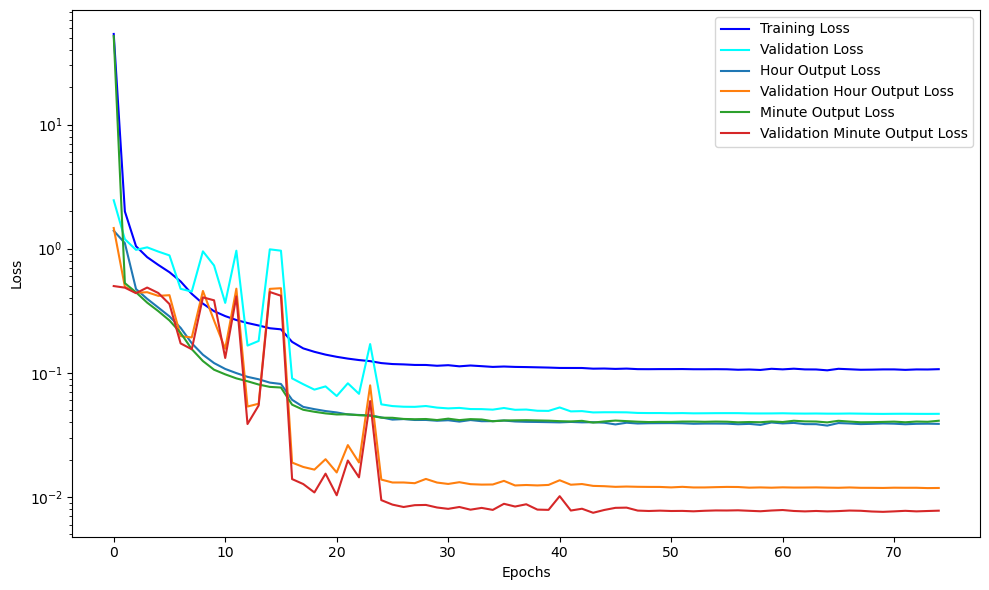

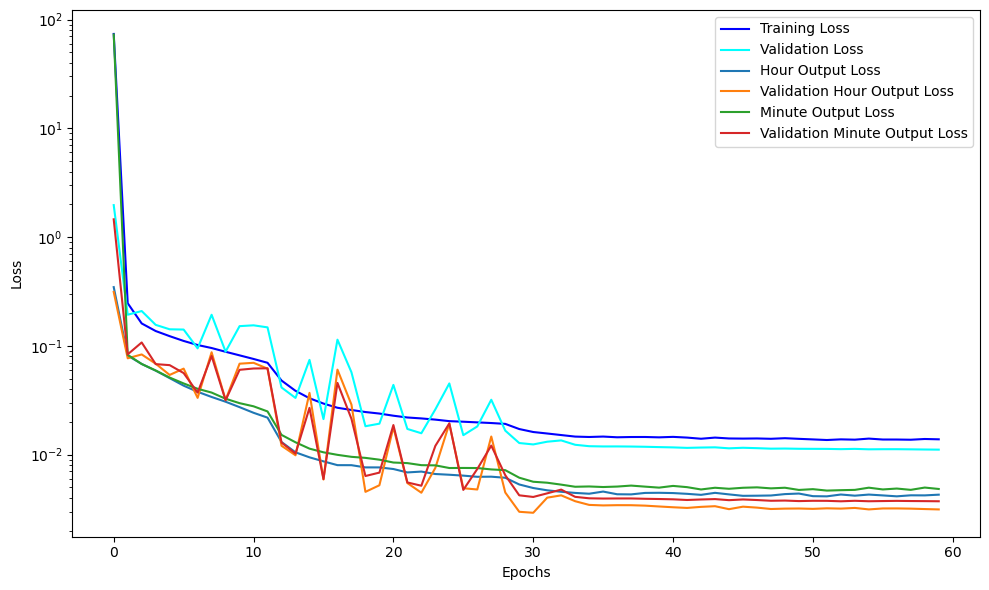

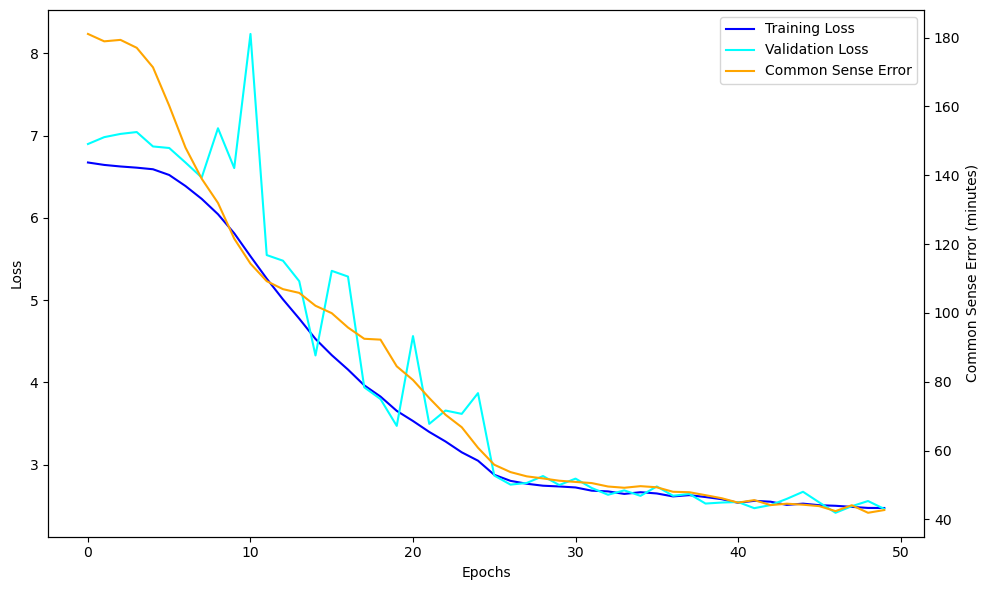

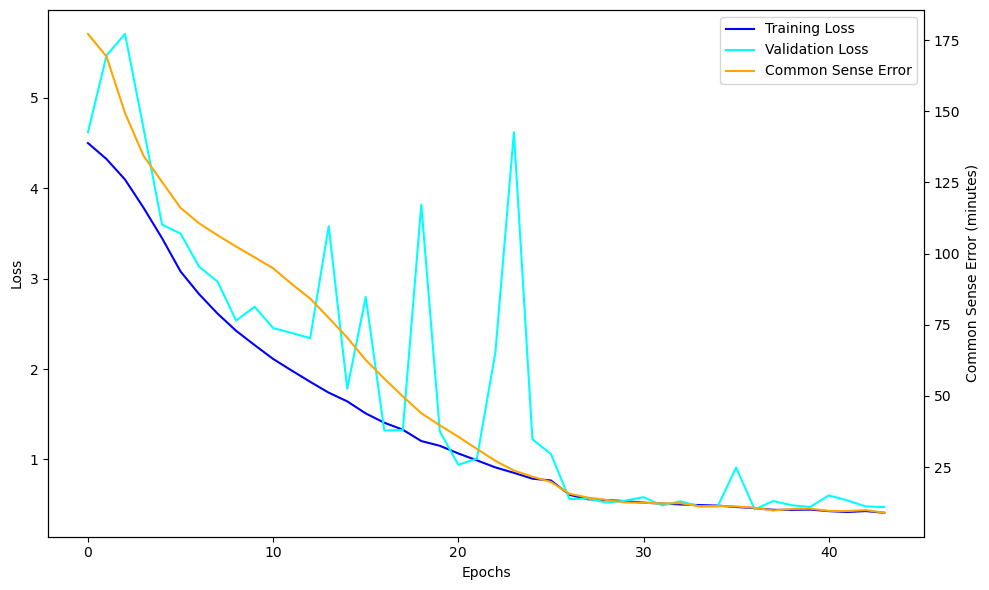

In [56]:
import os
import matplotlib.pyplot as plt
folder_path = "csv_logs"
for filename in os.listdir(folder_path):
    if 'log' in filename:
        file_path = os.path.join(folder_path, filename)
        print(f"Processing file: {file_path}")
        df = pd.read_csv(file_path)
        #plot training and validation loss curves
        fig, ax1 =plt.subplots(figsize=(10,6))
        ax2 = None
        ax1.plot(df['loss'], label='Training Loss', color='blue')
        ax1.plot(df['val_loss'], label='Validation Loss', color='cyan')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        #if there is a column 'common_sense_loss' plot it too on a separate axis
        if 'common_sense_loss' in df.columns:
            ax2 = plt.twinx()
            ax2.plot(df['common_sense_loss'], label='Common Sense Error', color='orange')
            ax2.set_ylabel('Common Sense Error (minutes)')
        #if "dual_head" in filename plot hour and minute output losses & use logarithmic scale
        if 'dual_head' in filename:
            ax1.plot(df['hour_output_loss'], label='Hour Output Loss')
            ax1.plot(df['val_hour_output_loss'], label='Validation Hour Output Loss')
            ax1.plot(df['minute_output_loss'], label='Minute Output Loss')
            ax1.plot(df['val_minute_output_loss'], label='Validation Minute Output Loss')
            ax1.set_yscale('log')
        #create a combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = [], []
        if ax2 is not None:
            lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
        fig.tight_layout()
        plt.savefig(f"{filename}_loss_curve.png")
